# Tutorial for the Single Top Workshop
Braga, Portugal from 10-12th December
<br>A. Sherman adsherma@bu.edu
<br>R. Zhang zhang@physik.uni-bonn.de


## Part 1: uproot + Keras

### [uproot](https://uproot.readthedocs.io/en/latest/) 

It is reader and a writer of the ROOT file format using only Python and Numpy.
It is only an I/O library, primarily intended to stream data into machine learning libraries in Python, and does not depend on C++ ROOT

#### Open root files and retrive trees

In [1]:
import uproot
uproot.open("tmva_class_example.root").keys()

[b'TreeS;1', b'TreeB;1']

In [2]:
tree_S = uproot.open("tmva_class_example.root")["TreeS"]
tree_S.keys()


[b'var1', b'var2', b'var3', b'var4']

In [3]:
tree_B = uproot.open("tmva_class_example.root")["TreeB"]
tree_B.keys()

[b'var1', b'var2', b'var3', b'var4', b'weight']

#### Retrieve events according to training variables

In [4]:
import pandas
events_S = tree_S.pandas.df(["var1", "var2", "var3", "var4"]).values
events_B = tree_B.pandas.df(["var1", "var2", "var3", "var4"]).values

Now the contents in a ROOT::TTree is stored in a numpy array called *events_S*.
<br> Have a look at *events_S*.

In [5]:
import numpy as np
np.set_printoptions(suppress=True)


### A tour of the input ROOT file

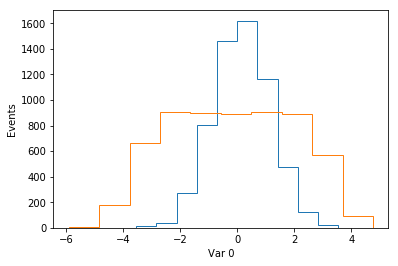

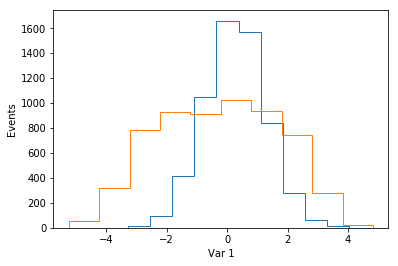

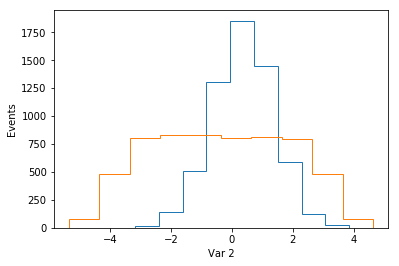

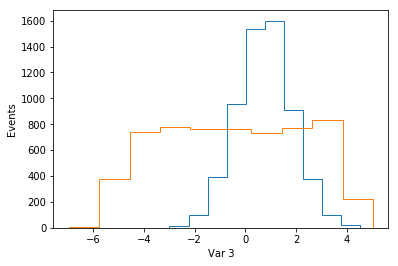

In [20]:
import matplotlib.pyplot as plt
for i in range(4):
    plt.hist(events_S.T[i], histtype='step')
    plt.hist(events_B.T[i], histtype='step')
    plt.ylabel('Events')
    plt.xlabel('Var '+str(i))
    plt.show()

<font color='blue'>No single variable could separate signal from background easily!</font>

### [Keras](https://keras.io)

It is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano.
<br>Runs seamlessly on CPU and GPU.

#### Split training and test samples
Craft target arrays for signal and background

In [7]:
from sklearn.model_selection import train_test_split
train_x_S, test_x_S = train_test_split(events_S, train_size=0.6, test_size=0.4)
train_x_B, test_x_B = train_test_split(events_B, train_size=0.6, test_size=0.4)

train_y_S = np.reshape([1 for x in range(len(train_x_S))], (len(train_x_S), 1))
test_y_S = np.reshape([1 for x in range(len(test_x_S))], (len(test_x_S), 1))
train_y_B = np.reshape([0 for x in range(len(train_x_B))], (len(train_x_B), 1))
test_y_B = np.reshape([0 for x in range(len(test_x_B))], (len(test_x_B), 1))

train_x = np.concatenate((train_x_S, train_x_B))
train_y = np.concatenate((train_y_S, train_y_B))
test_x = np.concatenate((test_x_S, test_x_B))
test_y = np.concatenate((test_y_S, test_y_B))

print(train_x_S.T[0])


[ 2.0007656   0.42832968  0.503272   ...  2.2109814   1.456481
 -0.17463984]


Check **shapes** of arrays
 - y=target should have a shape of (No. event, 1)
 - x=event should have a shape of (No. event, No. variable)

In [8]:
print(len(train_x), train_x.shape)
print(len(train_y), train_y.shape)
print(len(test_x), test_x.shape)
print(len(test_y), test_y.shape)


7200 (7200, 4)
7200 (7200, 1)
4800 (4800, 4)
4800 (4800, 1)


#### Build up a multi-layer neural network

In [9]:
from os import environ
environ['KERAS_BACKEND'] = 'theano'

from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
# Input - Layer
model.add(layers.Dense(4, activation = "relu", input_shape=(train_x.shape[1], )))
# Hidden - Layers
model.add(layers.Dense(4, activation = "elu"))
# model.add(layers.Dense(8, activation = "elu"))
# model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
# model.add(layers.Dense(8, activation = "elu"))
# model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
# model.add(layers.Dense(8, activation = "elu"))
# model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
# model.add(layers.Dense(8, activation = "relu"))
# Output - Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

Using Theano backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


#### Compile model before using it
Need to think about what *optimizer*, *loss*, *metrics* to use

In [10]:
from keras.optimizers import SGD

sgd = SGD(lr=0.01, momentum=0.8)
model.compile(optimizer = sgd, loss = "binary_crossentropy", metrics=['accuracy'])

#### Fit the model
We are now able to train/fit our model

In [11]:
results = model.fit(train_x, train_y, epochs= 100, batch_size = 512, validation_data = (test_x, test_y), verbose=1)
model.evaluate(train_x, train_y, verbose=0)
model.evaluate(test_x, test_y, verbose=0)


Train on 7200 samples, validate on 4800 samples
Epoch 1/100
7200/7200 [==============================] - 0s 4us/step - loss: 1.0036 - acc: 0.4053 - val_loss: 0.7149 - val_acc: 0.4731
Epoch 2/100
7200/7200 [==============================] - 0s 5us/step - loss: 0.6835 - acc: 0.5469 - val_loss: 0.6690 - val_acc: 0.5806
Epoch 3/100
7200/7200 [==============================] - 0s 7us/step - loss: 0.6603 - acc: 0.5811 - val_loss: 0.6545 - val_acc: 0.5808
Epoch 4/100
7200/7200 [==============================] - 0s 5us/step - loss: 0.6470 - acc: 0.5840 - val_loss: 0.6427 - val_acc: 0.5810
Epoch 5/100
7200/7200 [==============================] - 0s 6us/step - loss: 0.6345 - acc: 0.5854 - val_loss: 0.6299 - val_acc: 0.5800
Epoch 6/100
7200/7200 [==============================] - 0s 5us/step - loss: 0.6206 - acc: 0.5856 - val_loss: 0.6158 - val_acc: 0.5823
Epoch 7/100
7200/7200 [==============================] - 0s 7us/step - loss: 0.6054 - acc: 0.5899 - val_loss: 0.6001 - val_acc: 0.5850
Epoch 8

Epoch 61/100
7200/7200 [==============================] - 0s 4us/step - loss: 0.3224 - acc: 0.8544 - val_loss: 0.3364 - val_acc: 0.8554
Epoch 62/100
7200/7200 [==============================] - 0s 3us/step - loss: 0.3247 - acc: 0.8526 - val_loss: 0.3350 - val_acc: 0.8533
Epoch 63/100
7200/7200 [==============================] - 0s 3us/step - loss: 0.3225 - acc: 0.8544 - val_loss: 0.3332 - val_acc: 0.8567
Epoch 64/100
7200/7200 [==============================] - 0s 4us/step - loss: 0.3223 - acc: 0.8532 - val_loss: 0.3346 - val_acc: 0.8550
Epoch 65/100
7200/7200 [==============================] - 0s 3us/step - loss: 0.3254 - acc: 0.8517 - val_loss: 0.3334 - val_acc: 0.8552
Epoch 66/100
7200/7200 [==============================] - 0s 3us/step - loss: 0.3223 - acc: 0.8560 - val_loss: 0.3333 - val_acc: 0.8560
Epoch 67/100
7200/7200 [==============================] - 0s 3us/step - loss: 0.3227 - acc: 0.8543 - val_loss: 0.3333 - val_acc: 0.8548
Epoch 68/100
7200/7200 [========================

[0.33071945716937384, 0.8541666666666666]

#### Check results

1. Plot **loss** and **accuracy** for each epoch

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


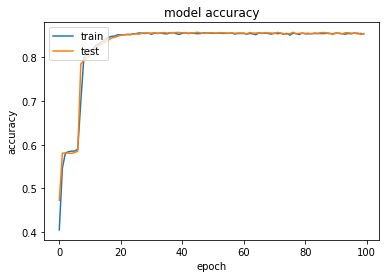

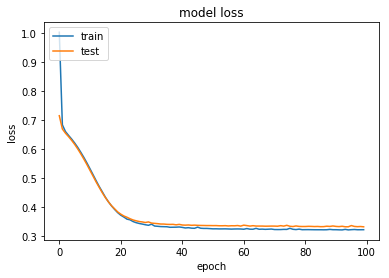

In [12]:
import matplotlib.pyplot as plt

print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is time to evaluate our model:

In [13]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)


2. Plot **ROC**

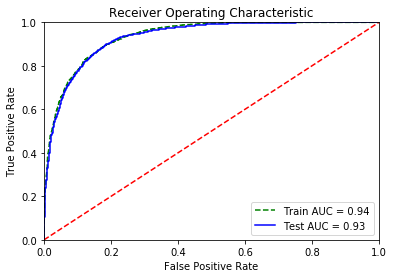

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plotROC(test_y, test_predict, train_y, train_predict):
    train__false_positive, train__true_positive, train__thresholds = roc_curve(train_y, train_predict)
    test__false_positive, test__true_positive, test__thresholds = roc_curve(test_y, test_predict)
    train__roc_auc = auc(train__false_positive, train__true_positive)
    test__roc_auc = auc(test__false_positive, test__true_positive)

    plt.title('Receiver Operating Characteristic')
    plt.plot(train__false_positive, train__true_positive, 'g--', label='Train AUC = %0.2f'% train__roc_auc)
    plt.plot(test__false_positive, test__true_positive, 'b', label='Test AUC = %0.2f'% test__roc_auc)

    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.,1.])
    plt.ylim([-0.,1.])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
#     plt.gcf().clear()

plotROC(test_y, test_predict, train_y, train_predict)

In [15]:
from sklearn.metrics import roc_auc_score

print('Traing ROC: ', roc_auc_score(train_y, train_predict))
print('Test ROC:   ', roc_auc_score(test_y, test_predict))


Traing ROC:  0.9357265817901234
Test ROC:    0.9316185763888889


3. Plot **distributions**

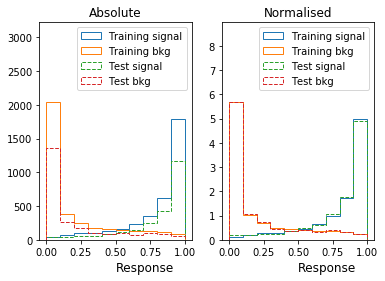

In [16]:
xlo, xhi, nbin = 0.,1,10
def plotResponse(test_y, test_predict, train_y, train_predict):

    plt.subplot(1, 2, 1)
    plt.hist(train_predict[train_y == 1], range=[xlo, xhi], bins=nbin, histtype="step", density=0, label='Training signal')
    plt.hist(train_predict[train_y == 0], range=[xlo, xhi], bins=nbin, histtype="step", density=0, label='Training bkg')
    plt.hist(test_predict[test_y == 1],   range=[xlo, xhi], bins=nbin, histtype="step", density=0, label='Test signal', linestyle='dashed')
    plt.hist(test_predict[test_y == 0],   range=[xlo, xhi], bins=nbin, histtype="step", density=0, label='Test bkg', linestyle='dashed')
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.5)
    plt.legend()
    plt.xlabel('Response', horizontalalignment='left', fontsize='large')
    plt.title('Absolute')

    plt.subplot(1, 2, 2)
    plt.hist(train_predict[train_y == 1], range=[xlo, xhi], bins=nbin, histtype="step", density=1, label='Training signal')
    plt.hist(train_predict[train_y == 0], range=[xlo, xhi], bins=nbin, histtype="step", density=1, label='Training bkg')
    plt.hist(test_predict[test_y == 1],   range=[xlo, xhi], bins=nbin, histtype="step", density=1, label='Test signal', linestyle='dashed')
    plt.hist(test_predict[test_y == 0],   range=[xlo, xhi], bins=nbin, histtype="step", density=1, label='Test bkg', linestyle='dashed')
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.5)
    plt.legend()
    plt.xlabel('Response', horizontalalignment='left', fontsize='large')
    plt.title('Normalised')

    plt.show()
#     plt.gcf().clear()

plotResponse(test_y, test_predict, train_y, train_predict)


### Execises

1. Set learning rate to 0.2 and see what will happen
<br>SGD(lr=0.2)
2. Switch back to rl=0.01, and set SGD momentum to 0.9
<br>SGD(momentum=0.9)

## Part 2: Implementing

#### Save model to disk
Hierarchical Data Format (**HDF**) is a set of file formats (HDF4, HDF5) designed to store and organize large amounts of data.

h5 file containes:
- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

In [17]:
def SaveModel(model):
    filePre = 'KerasModel'
    # serialize model to JSON
    model_json = model.to_json()
    with open(filePre + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filePre + ".h5")
    print("Saved "+ filePre + " to disk")

SaveModel(model)

Saved KerasModel to disk


#### Load model from disk

In [18]:
from keras.models import model_from_json

def LoadModel():
    filePre = 'KerasModel'
    # load json and create model
    json_file = open(filePre + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(filePre + '.h5')
    print("Loaded "+ filePre + " from disk")
    return loaded_model

loaded_model = LoadModel()

Loaded KerasModel from disk


#### Store response to ROOT files


<font color='red'>uproot does not support writing TTree yet!</font>
<font color='red'><br>Current recommendation is using [root_numpy](http://scikit-hep.org/root_numpy/)</font>
<font color='red'><br>Histogram is supported though.</font>


In [19]:
import uproot, numpy
f = uproot.recreate("Templates.root")
f["Train_bkg"] = numpy.histogram(train_predict[train_y == 0])
f["Train_signal"] = numpy.histogram(train_predict[train_y == 1])
f["Test_bkg"] = numpy.histogram(test_predict[test_y == 0])
f["Test_signal"] = numpy.histogram(test_predict[test_y == 1])